In [32]:
##importing required libraries
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random 
import kaggle
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

If importing kaggle is giving you auth error most probably you havent added the api from kaggle
To do so:
- Login to kaggle
- Profile -> Settings -> API -> create Token
- A json file will be downloaded now paste it to your root directory/.kaggle eg: C/Users/arati/.kaggle

In [6]:
#Downloading Data
# Set the Kaggle dataset and file details
kaggle_dataset = 'deadskull7/fer2013'  # Example: 'zillow/zecon'
file_name = 'fer2013.csv'  # Name of the file you want to download
data_folder = '../data'

# Create data directory if it does not exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
if not os.path.exists(os.path.join(data_folder, file_name)):
    try:
        # Download the dataset file from Kaggle
        kaggle.api.dataset_download_file(dataset=kaggle_dataset, file_name=file_name, path=data_folder)
        # Define the path to the downloaded zip file
        zip_file_path = os.path.join(data_folder, file_name+'.zip')
        
        # Unzip the file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(data_folder)

        # Remove the zip file after extraction
        os.remove(zip_file_path)
        print('Data downloaded and extracted.')

    except Exception as e:
        print(f"An error occurred: {e}")


In [7]:
##import the dataset
faces = pd.read_csv('../data/fer2013.csv')
faces.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
faces.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [9]:
faces.nunique()


emotion        7
pixels     34034
Usage          3
dtype: int64

## Dataset Description
The given dataset has 3 features which are:
- Emotion: Label encoded feature with 7 different emotions.
    - 0: Angry
    - 1: Digust
    - 2: Fear
    - 3: Happy
    - 4: Sad
    - 5: Surprise
    - 6: Neutral 
- Pixels: This is a flattened array of pixels of a black and white 48x48 pixels face picture in string format
- Usage: Label for the picture whether to use them as training or testing or validation


In [10]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = faces['emotion'].value_counts().reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Happy,8989
1,Neutral,6198
2,Sad,6077
3,Fear,5121
4,Angry,4953
5,Surprise,4002
6,Digust,547


It seems the data is not balanced properly as some classes like disgust is way sparse than the class happy. WE can use some augmentation techniques to handle the imbalance or even SMOTE during training

In [11]:
faces['Usage'].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

Lets drop this column so we can apply augmentation to the minority class and stratify the classes later for training and validation.

In [12]:
faces = faces.drop(columns = ['Usage'])

In [13]:
##Lets check some of the faces
faces.sample(n=10)

,emotion,pixels
21720,4,169 170 179 183 83 65 76 76 76 87 90 84 89 87 ...
6533,5,0 0 0 1 1 0 0 1 8 8 8 38 44 36 59 69 73 88 100...
26702,4,149 99 111 180 230 228 230 225 222 221 225 224...
23694,2,75 80 87 98 102 106 110 109 113 112 108 109 11...
24021,0,50 60 49 55 59 55 69 75 76 69 63 61 46 34 25 2...
14445,0,252 252 251 251 251 250 254 240 79 38 48 44 41...
33350,2,209 210 210 210 210 211 211 210 210 210 211 21...
14351,6,23 7 6 4 6 5 4 4 4 4 4 6 6 8 9 8 11 14 16 16 1...
3958,3,80 96 98 73 80 76 75 80 80 84 93 96 88 75 88 7...
28625,6,216 217 215 210 202 191 167 62 35 35 36 56 47 ...


In [14]:
#Lets create a funtion to convert the pixel values to array so that we can plot it
type(faces['pixels'][0])

str

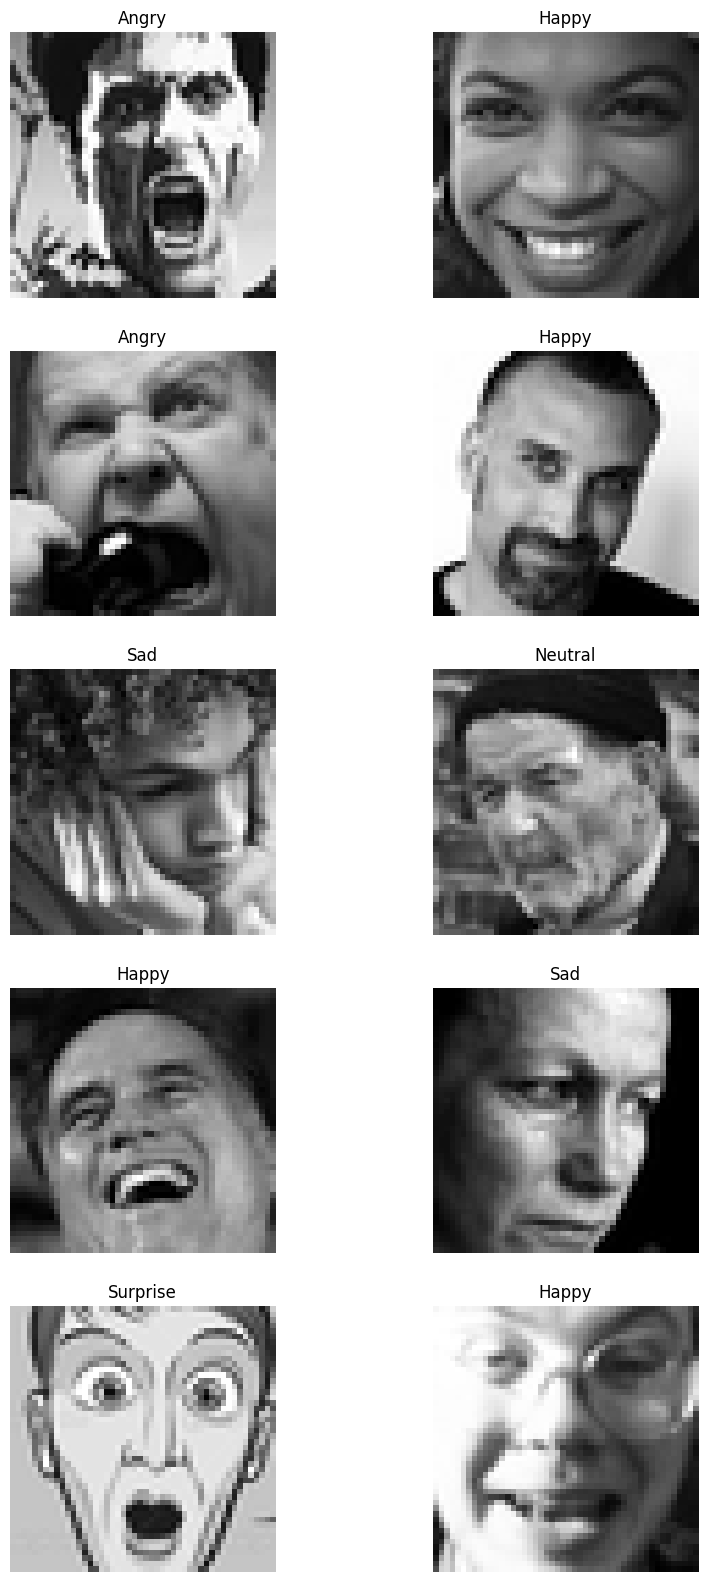

In [15]:
def get_image(row):
    pixels = row['pixels']
    emotion = emotion_map[row['emotion']]
    img = np.array(pixels.split(),dtype =float) 
    #this will give a list from the string for instance [233,181,135]. 
    #pixels.split gives a list and np.array converts the list to array
    img = img.reshape(48,48) # reshape the 1d array to 2d array of dimensions 48x48
    return (img.astype(np.uint8), emotion) #return tuple of img with required datatype and emotion label

samples = faces.sample(n = 10).reset_index() #getting 8 random
plt.figure(0, figsize=(10,20))
for index, row in samples.iterrows():
    img = get_image(row)
    plt.subplot(5,2,index+1)
    plt.imshow(img[0],cmap='gray')
    plt.title(img[1])
    plt.axis('off')
    
plt.show()  

In [16]:
classes, class_counts = np.unique(faces['emotion'], return_counts=True)
mid_count = np.median(class_counts)  #this returns the max number of samples in the classes that is happy
print(f'The median number of samples in a class is',mid_count)

The median number of samples in a class is 5121.0


In [17]:
print(classes, class_counts) #just for visualization

[0 1 2 3 4 5 6] [4953  547 5121 8989 6077 4002 6198]


Lets apply image augmentation to increase the number of samples in minority classes. Here, we will apply augmentation to all the minority classes so that the number of images in each class is equal to the median number of samples that is 5121 images per class.
For now we will do the augmentation in the whole dataset. this may lead to overfitting. Correct approach would be to separate the data into train test and val first and then augmentation only in the training dataset. But as a trial, we will do it.

In [18]:
#Use tensorflow's Data augmentation tool to augment the images
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
) #apply transformations to images so new images can be generated from the  images


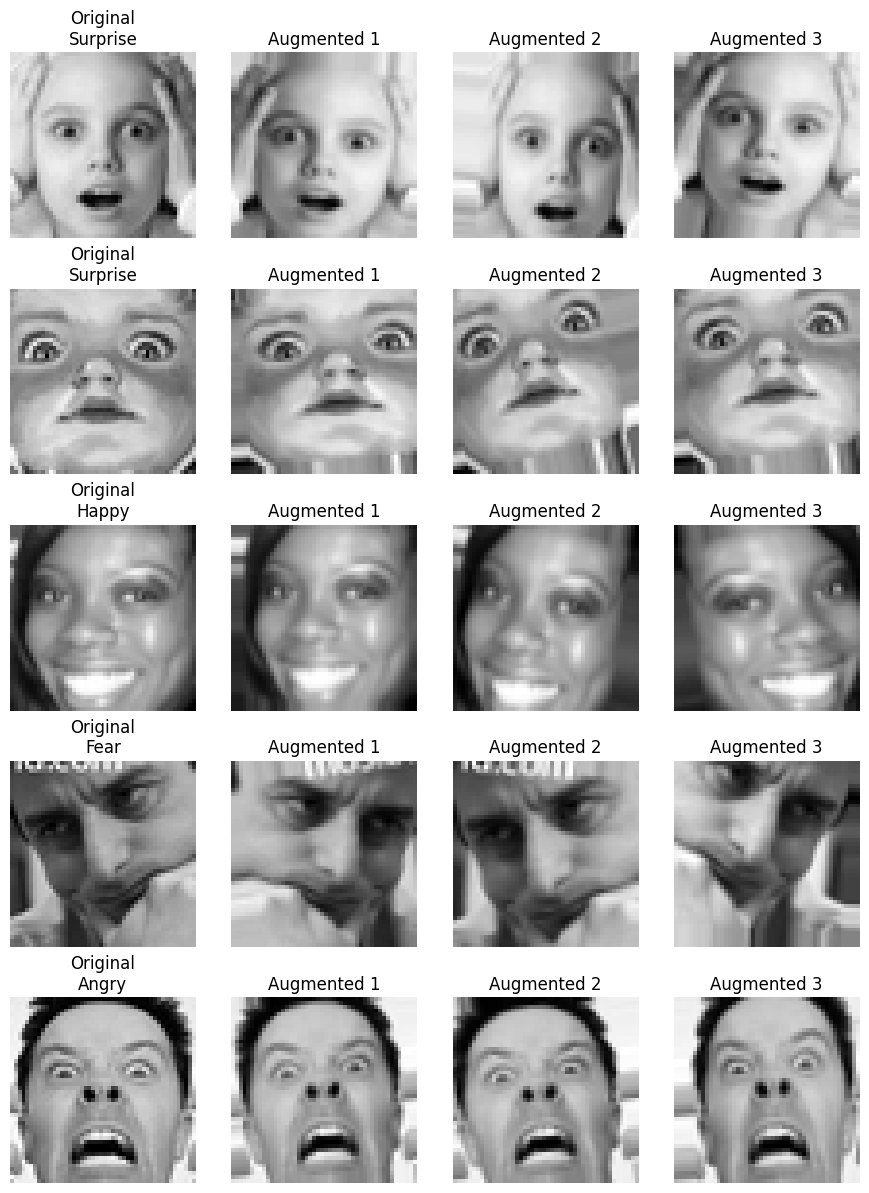

In [19]:
#Before applying in the dataset, lets show what type of augmentation does the datagen do
samples = faces.sample(n=5).reset_index(drop=True)
# Create a figure with a grid of 5 rows and 4 columns (1 for original, 3 for augmented)
plt.figure(figsize=(9,12 ))

# Loop through the sampled images and plot each one
for index, row in samples.iterrows():
    img, emotion_label = get_image(row)  # Get image and emotion label
    
    # Display original image
    plt.subplot(5, 4, index*4+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{emotion_label}")
    plt.axis('off')
    # For augmentation, tensorflow expects a 4d array in the format (batch_size, height, width, channels) 
    # Add channel dimension for grayscale images
    img = img[:, :, np.newaxis]  # Shape becomes (48, 48, 1)
    img = np.expand_dims(img, axis=0)  # Add batch dimension for augmentation
    augmented_images = datagen.flow(img, batch_size=1) 
    
    for i in range(3):  # Show 3 augmented versions
        augmented_image = next(augmented_images)[0].astype(np.uint8)
        plt.subplot(5, 4, index*4 + 2 + i)
        plt.imshow(augmented_image, cmap='gray')
        plt.title(f"Augmented {i+1}")
        plt.axis('off')

plt.tight_layout() 
plt.show()

In [21]:

# Initialize lists to accumulate data
images_list = []
labels_list = []

for label in classes:
    # Get all images of the current class
    class_imgs = faces[faces['emotion'] == label]
    
    # get just the image in array format
    class_imgs = np.array([get_image(row)[0] for index, row in class_imgs.iterrows()])
    
    # Ensure images are in the format (num_samples, 48, 48)
    class_imgs = class_imgs[..., np.newaxis] 

    aug_count = mid_count - class_imgs.shape[0]  # Number of augmentations needed
    
    for img in class_imgs:
        images_list.append(img)
        labels_list.append(label)
    if aug_count <= 0:
        print('No augmentations needed for class',emotion_map[label])
    else:
        # No need for augmentation; just add existing images:
        print(aug_count,'augmentations needed for class',emotion_map[label])
        # Perform augmentation
        images_needed = aug_count
        while images_needed > 0:
            # choose a random image from the class
            img = random.choice(class_imgs)    
            img = np.expand_dims(img, axis=0)  # Add batch dimension (1, 48, 48, 1)
            aug_imgs = datagen.flow(img, batch_size=1)

            # Generate augmented images
            new_img = next(aug_imgs)[0].astype(np.uint8)
            
            images_list.append(new_img)
            labels_list.append(label)
            images_needed -= 1

# Convert lists to DataFrame
balanced_df = pd.DataFrame({
    'image': images_list,
    'label': labels_list
})

print("Augmentation Complete")

168.0 augmentations needed for class Angry
4574.0 augmentations needed for class Digust
No augmentations needed for class Fear
No augmentations needed for class Happy
No augmentations needed for class Sad
1119.0 augmentations needed for class Surprise
No augmentations needed for class Neutral
Augmentation Complete


In [22]:
len(balanced_df)

41748

In [23]:
balanced_df['label'].value_counts()

label
3    8989
6    6198
4    6077
0    5121
1    5121
2    5121
5    5121
Name: count, dtype: int64

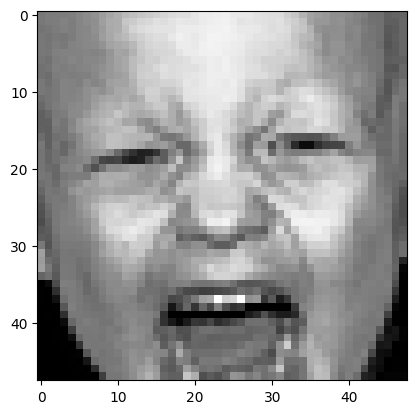

In [24]:
plt.imshow(balanced_df['image'][2343],cmap = 'gray')

In [27]:
balanced_df.head()


,image,label
0,"[[[70], [80], [82], [72], [58], [58], [60], [6...",0
1,"[[[151], [150], [147], [155], [148], [133], [1...",0
2,"[[[30], [24], [21], [23], [25], [25], [49], [6...",0
3,"[[[123], [125], [124], [142], [209], [226], [2...",0
4,"[[[8], [9], [14], [21], [26], [32], [37], [46]...",0


In [29]:
X = balanced_df['image']
y = balanced_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [30]:
X_test,X_val,y_test,y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [31]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(29223,)
(6262,)
(6263,)


In [35]:
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

from keras.utils import to_categorical
def CRNO(X,y, dataName):
    data_X = np.array(X.tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(y, num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(X_train,y_train,"train") #training data
val_X, val_Y     = CRNO(X_val,y_val, "val") #validation data
test_X, test_Y   = CRNO(X_test,y_test, "test") #test data

train _X shape: {},  train _Y shape: (29223, 48, 48, 1)
val _X shape: {},  val _Y shape: (6263, 48, 48, 1)
test _X shape: {},  test _Y shape: (6262, 48, 48, 1)


In [37]:

model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

c:\Users\bimal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 46, 46, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 46, 46, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 46, 46, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 46, 46, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 46, 46, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 23, 23, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 23, 23, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 11, 11, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             

 Total params: 2,137,991 (8.16 MB)

 Trainable params: 2,134,407 (8.14 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [38]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
history = model.fit(train_X, train_Y,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_X, val_Y))

Epoch 1/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 1195s 1s/step - accuracy: 0.3135 - loss: 1.7776 - val_accuracy: 0.4903 - val_loss: 1.3786
Epoch 2/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 1055s 1s/step - accuracy: 0.5496 - loss: 1.2098 - val_accuracy: 0.5287 - val_loss: 1.2532
Epoch 3/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 1058s 1s/step - accuracy: 0.6118 - loss: 1.0377 - val_accuracy: 0.5389 - val_loss: 1.3174
Epoch 4/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 1566s 2s/step - accuracy: 0.6543 - loss: 0.9282 - val_accuracy: 0.6039 - val_loss: 1.0649
Epoch 5/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 1533s 2s/step - accuracy: 0.6973 - loss: 0.8221 - val_accuracy: 0.5687 - val_loss: 1.2388
Epoch 6/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 1704s 2s/step - accuracy: 0.7358 - loss: 0.7186 - val_accuracy: 0.6082 - val_loss: 1.1238
Epoch 7/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 1540s 2s/step - accuracy: 0.7780 - loss: 0.6046 - val_accuracy: 0.6130 - val_loss: 1.2282
Epoch 8/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 1676s 2s/step - accuracy: 0.8183 - loss: 0.5045 - 

In [42]:
import pickle
with open('model_1.pkl', 'wb') as file:
    pickle.dump(model, file)

Sanjog rasaili
